### Abstract

We are interested to understand how people adjust their behaviour to the underlying temporal structure of changes. For this purpose we have modified a standard reversal learning task to include exploratory (epistemic) choices, which participants can use to learn the correct choice on the current trial. Participants were separated in two groups, each group exposed to different experimental conditions characterised by a different temporal structure of reversals.

In the first condition participants were exposed to regular (predictable) reversals for 800 trials and then to irregular sequence of reversals for 200 trials (same reversal rate but les predictable moment of reversals). In the second condition, the participant were first exposed to the irregular reversals (for 800 trials) and then to a sequence of regular reversal 200 trials.

Quanitfying probability of exploratory choices at each trial relative to the moment of reversals we can identify distinct characteristic responses of behaviour in two experimental conditions. This results suggest that people are sensitive to the temporal structure of the reversals (they can learn it) and that they use this structure for infering most likely moments of reversals, as reflected in the statistics of exploratory choices.

In [1]:
# load behavioural data
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(context='talk', style = 'white', color_codes = True)
%matplotlib inline

import sys

from os import getcwd, listdir
from os.path import isfile, join, expanduser

from scipy import io

conds = ['reg', 'irr']

def load_data(fnames, path):
    data = pd.DataFrame()
    n = 0
    for j,f in enumerate(fnames):
        sub = f.split('_')[-4]
        tmp = io.loadmat(data_path + f)
        df = pd.DataFrame()
        df['offer'] = np.abs(tmp['random_lr']-2).flatten()
        df['response'] = tmp['A'].flatten() - 1
        df['explore'] = df['response'] == 2
        df['correct'] = tmp['C'].flatten()
        df['outcome'] = tmp['Rew'].flatten()
        if tmp['RT'].shape[-1] < len(df):
            RT = np.concatenate([tmp['RT'], np.zeros((1, 1))*np.nan], -1)
        else:
            RT = tmp['RT']
        df['RT'] = RT.flatten()
        df['S'] = tmp['S'].flatten()
        df['change'] = np.abs(df['S'].diff())
        df['ID'] = sub
        df['subject'] = n
        condition = int(tmp['blockorder'])
        df['condition'] = conds[condition]
        df['trial'] = np.arange(1, 1001)
        data = data.append(df, ignore_index=True)
        n += 1
    
    return data
    

home = expanduser('~')
cwd = getcwd()
sys.path.append(cwd[:-len('befit/examples/temp_rev_learn')])

group = ['Teens', 'OldAdults', 'YoungAdults']
data = pd.DataFrame()
for g in group:
    data_path = home + '/tudcloud/Shared/reversal/' + g + '/data/'
    fnames = [f for f in listdir(data_path) if isfile(join(data_path, f))]

    df = load_data(fnames, data_path)
    df['group'] = g
    data = data.append(df, ignore_index=True)

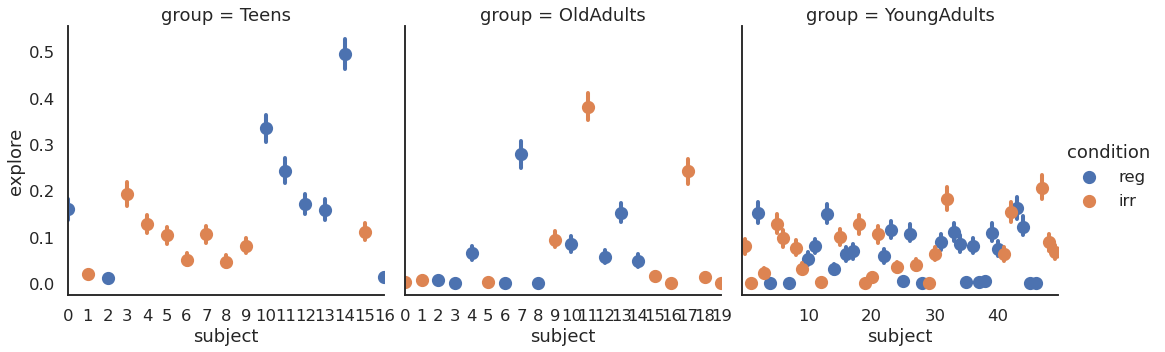

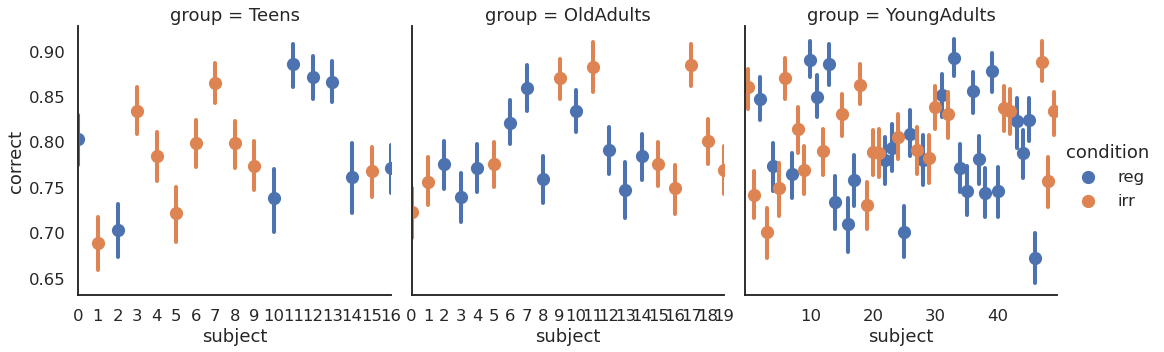

In [2]:
kwargs = {'linestyles': '', 'sharex': False}
g = sns.catplot(x='subject', y='explore', data=data, hue='condition', col='group', kind='point', **kwargs);
g.axes[0, 0].set_xlim([0, 16])
g.axes[0, 1].set_xlim([0, 19])
g.axes[0, 2].set_xticks([10, 20, 30, 40]);

kwargs = {'linestyles': '', 'sharex': False}
g = sns.catplot(x='subject', y='correct', data=data, hue='condition', col='group', kind='point', **kwargs);
g.axes[0, 0].set_xlim([0, 16])
g.axes[0, 1].set_xlim([0, 19])
g.axes[0, 2].set_xticks([10, 20, 30, 40]);

In [19]:
trials = 1000

def count_duration(x):
    return np.diff(np.concatenate(([0], np.nonzero(np.nan_to_num(np.diff(x), nan=1))[0] + 1, [len(x)])))
    
def get_durations(x):
    N = x.shape[-1]
    
    d_max = 100
    D = np.zeros((N, d_max))
    for n in range(N):
        D[n] = np.histogram(count_duration(x[:, n]), bins=range(d_max + 1))[0]
    return D

def get_reversal_statistics(data, delta=200):
    
    irr_reversal = data.groupby(['group', 'condition', 'subject']).get_group(('OldAdults', 'irr', 0))['change'].values
    irr_reversal[0] = 0
    irr_reversal = irr_reversal.astype(bool)
    reg_reversal = data.groupby(['group', 'condition', 'subject']).get_group(('OldAdults', 'reg', 2))['change'].values
    reg_reversal[0] = 0
    reg_reversal = reg_reversal.astype(bool)
    
    reversal = {
        'reg': reg_reversal,
        'irr': irr_reversal
    }
    conditions = ['reg', 'irr']
    performance = {}
    exploration = {}
    D = {}
    for group in np.unique(data.group):
        df_g = data.loc[data.group == group]
        E = df_g.pivot(index='trial', columns='subject', values='response').values == 2
        C = df_g.pivot(index='trial', columns='subject', values='correct').values
        
        performance.setdefault(group, {})
        exploration.setdefault(group, {})
        D.setdefault(group, {})
        
        for cond in conditions:
            subs = np.unique(df_g.groupby(['condition']).get_group((cond))['subject'])
            trials = np.sort(np.unique(df_g.trial))[reversal[cond]]
            count = np.nansum(E[-400:, subs], 0)
            loc = count > 10
            loc *= count < 150
            D[group][cond] = get_durations(C[:, subs])
            performance[group].setdefault(cond, {})
            exploration[group].setdefault(cond, {})
            for t in trials:
                block = np.long(np.floor(t/delta))
                performance[group][cond].setdefault(block, [])
                performance[group][cond][block].append(C[t-10:t+10, subs])
                
                exploration[group][cond].setdefault(block, [])
                exploration[group][cond][block].append(E[t-10:t+10, subs[loc]])
            
            for b in range(block + 1):
                performance[group][cond][b] = np.stack(performance[group][cond][b])
                exploration[group][cond][b] = np.stack(exploration[group][cond][b])
            
    return performance, exploration, D

performance, exploration, D = get_reversal_statistics(data);

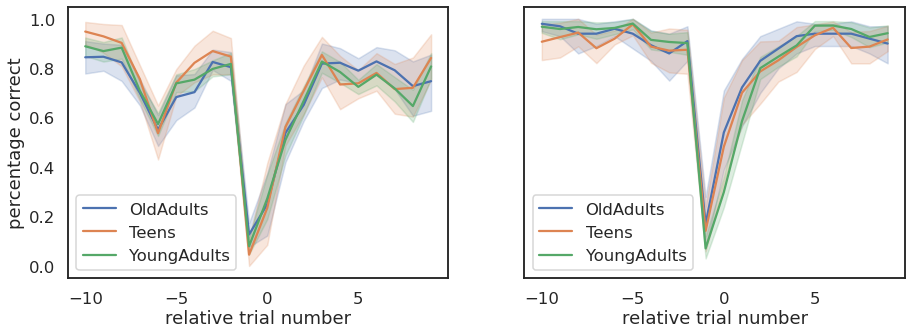

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

for group in performance:
    for i, cond in enumerate(performance[group]):
        block = 4
        df = pd.DataFrame(np.nanmean(performance[group][cond][block], 0))
        df['relative trial number'] = np.arange(-10, 10, 1)
        df = df.melt(id_vars='relative trial number', value_name='percentage correct')
        sns.lineplot(x='relative trial number', y='percentage correct', data=df, label=group, ax=axes[i])

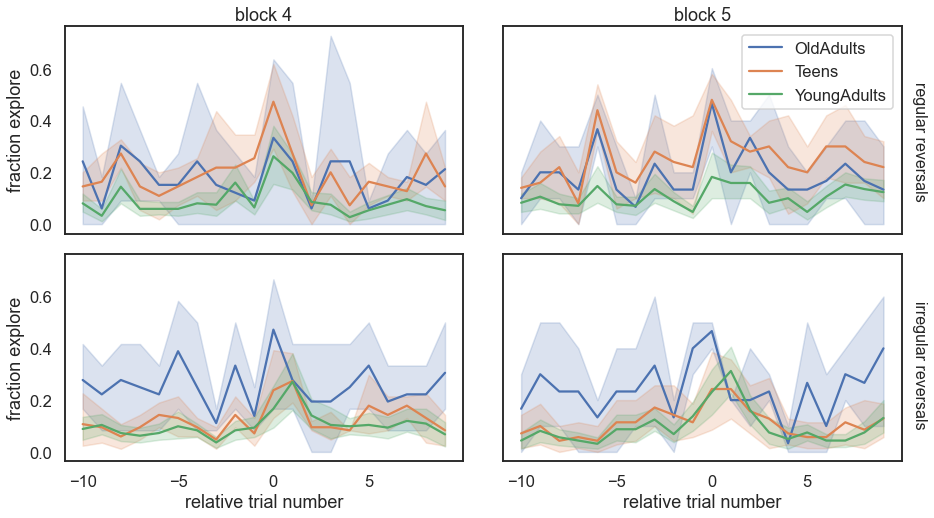

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 8), sharex=True, sharey=True, gridspec_kw={'hspace': .1, 'wspace': .1})

for group in exploration:
    for i, cond in enumerate(exploration[group]):
        for j, block in enumerate([3, 4]):
            df = pd.DataFrame(np.nanmean(exploration[group][cond][block], 0))
            df['relative trial number'] = np.arange(-10, 10, 1)
            df = df.melt(id_vars='relative trial number', value_name='fraction explore')
            sns.lineplot(x='relative trial number', y='fraction explore', data=df, label=group, ax=axes[i, j], legend=False)

axes[0, 1].legend()
axes[0, 0].set_title('block 4');
axes[0, 1].set_title('block 5');

axes[0, 1].text(x=10.5, y=.1, s='regular reversals', rotation=-90, fontsize=16);
axes[1, 1].text(x=10.5, y=.1, s='irregular reversals', rotation=-90, fontsize=16);

fig.savefig('Fig2.png', dpi=300)

## Estimate switch probability between groups and conditions

In [30]:
tmp = io.loadmat('pilot/states_and_rewards.mat')
Sirr = tmp['irregular']['S'][0, 0][:, 0] - 1
Oirr = tmp['irregular']['R'][0, 0]
Sreg = tmp['regular']['S'][0, 0][:, 0] - 1
Oreg = tmp['regular']['R'][0, 0]
states ={
    'reg': Sreg,
    'irr': Sirr
}

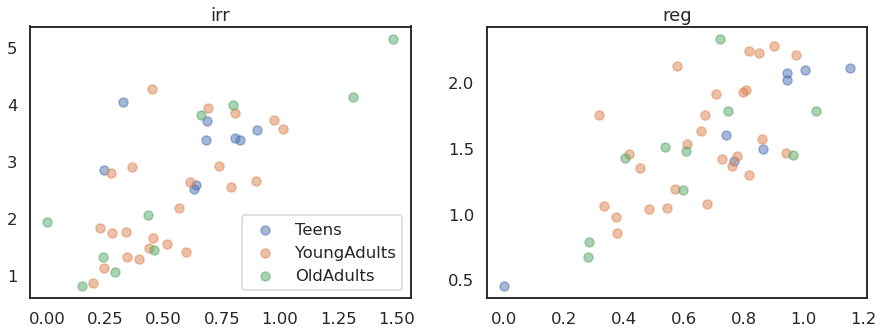

In [34]:
from stats import trials_until_correct, running_mean

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
color = ['b', 'r']

for i, cond in enumerate(['irr', 'reg']):
    for j, group in enumerate(['Teens', 'YoungAdults', 'OldAdults']):
        df = data.loc[data.condition == cond]
        df = df.loc[df.group == group]
        corrects = np.nan_to_num(df.pivot(index='trial', columns='subject', values='correct').values)
        tuc = trials_until_correct(corrects.T, states[cond][None], τ=3)
        mean_tuc = running_mean(tuc, ws=201)
        axes[i].scatter(mean_tuc[..., 400:].min(-1), mean_tuc[..., 400:].max(-1), alpha=.5, label=group)
    axes[i].set_title(cond)
    
axes[0].legend()

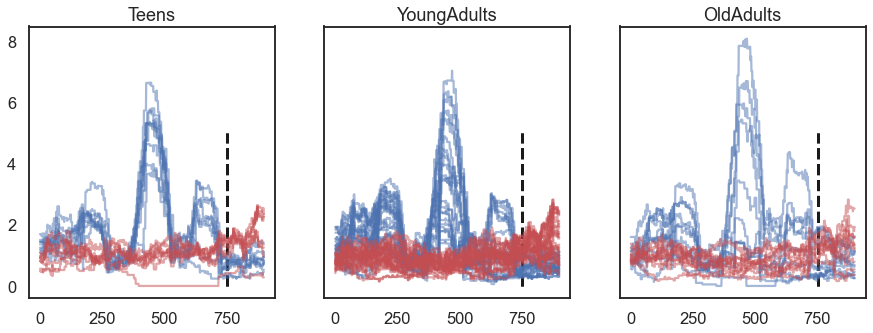

In [107]:
def trials_until_correct(correct, state, τ=2):
    # mark trial on which state switch occured
    state_switch = np.insert(np.abs(np.diff(state, axis=-1)), 0, 0, axis=-1)
    
    count = np.zeros(state_switch.shape[0]) # counter trials since the last switch
    cum_corr = np.zeros(correct.shape[:-1]) # counter for corect responses in a sequence
    trials_until_correct = np.zeros(correct.shape)
    for t in range(state_switch.shape[-1]):
        # increase counter if state did not switch, otherwise reset to 1
        count = (count + 1) * (1 - state_switch[..., t]) + state_switch[..., t]
        
        # if choice was correct increase by 1, otherwise reset to 0
        cum_corr = (cum_corr + 1) * correct[..., t]
        
        # check if the number of correct choices matches the threshold value
        at_threshold = cum_corr == τ
        
        # update only valid dimensions for which count is larger than the threshold
        valid = count >= τ
        
        # mark count for valid dimensions (participants) which satisfy the condition
        # all the other elements are set to NaN
        trials_until_correct[..., t] = np.where(valid * at_threshold, count, np.nan)
    
    # retrun mean trials until correct across the experiment for each participant and sample
    return trials_until_correct

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
color = ['b', 'r']

for i, cond in enumerate(['irr', 'reg']):
    for j, group in enumerate(['Teens', 'YoungAdults', 'OldAdults']):
        df = data.loc[data.condition == cond]
        df = df.loc[df.group == group]
        correct = np.nan_to_num(df.pivot(index='trial', columns='subject', values='correct').values).T
        state = df.pivot(index='trial', columns='subject', values='S').values.T
        tuc = trials_until_correct(correct, state, τ=3)
        mean_tuc = running_mean(tuc, ws=100)
        axes[j].plot(mean_tuc.T, color[i], alpha=.5)
        axes[j].vlines(751, 0, 5, 'k', linestyle='--', lw=3)
        axes[j].set_title(group)

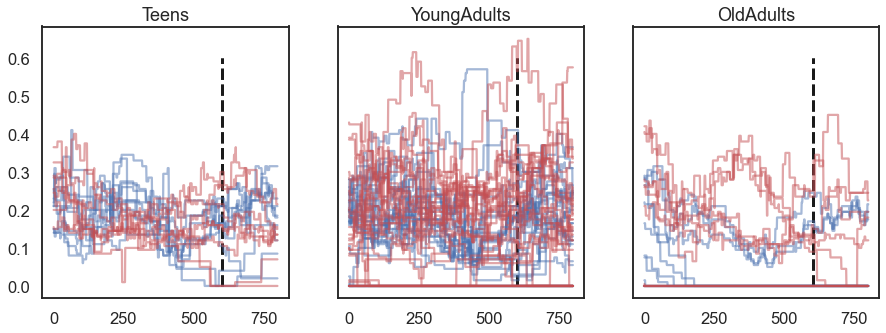

In [100]:
def trials_until_explore(explore, state):
    # mark trial on which state switch occured
    state_switch = np.insert(np.abs(np.diff(state, axis=-1)), 0, 0, axis=-1)
    
    count = np.zeros(state_switch.shape[0]) # counter trials since the last switch
    cum_explore = np.zeros(explore.shape[:-1]) # counter for corect responses in a sequence
    trials_until_explore = np.zeros(explore.shape)
    for t in range(state_switch.shape[-1]):
        # increase counter if state did not switch, otherwise reset to 1
        count = (count + 1) * (1 - state_switch[..., t]) + state_switch[..., t]
        
        # check if the response corresponds to explore
        at_explore = explore[..., t].astype(np.float)
        
        cum_explore = (cum_explore + 1) * at_explore + cum_explore * (1 - at_explore)
        cum_explore = cum_explore * (1 - state_switch[..., t])
        
        # update only valid dimensions for which this is first explore choice since the switch
        valid = cum_explore == 1
        
        # mark count for valid dimensions (participants) which satisfy the condition
        # all the other elements are set to NaN
        trials_until_explore[..., t] = np.where(valid * at_explore, count, np.nan)
    
    # retrun mean trials until correct across the experiment for each participant and sample
    return trials_until_explore

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
color = ['b', 'r']

for i, cond in enumerate(['irr', 'reg']):
    for j, group in enumerate(['Teens', 'YoungAdults', 'OldAdults']):
        df = data.loc[data.condition == cond]
        df = df.loc[df.group == group]
        explore = df.pivot(index='trial', columns='subject', values='explore').values.T
        state = df.pivot(index='trial', columns='subject', values='S').values.T
        tuc = trials_until_explore(explore, state)
        mean_tuc = running_mean(tuc, ws=200)
        axes[j].plot(mean_tuc.T, color[i], alpha=.5)
        axes[j].vlines(601, 0, .6, 'k', linestyle='--', lw=3)
        axes[j].set_title(group)